In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm, ticker
import os
import scipy.constants as sc
from scipy.optimize import bisect, newton
rcParams['figure.figsize'] = (4,2)

In [3]:
# radius
P = 400
r_in = 0.1 # disc inner radius in au
r_out = 400 # disc outer radius in au
R = np.logspace(np.log10(r_in), np.log10(r_out), P+1)
# mcfost_R = fits.open('/data/jhyl3/mcfost_files/run_07/data_disk_6/grid.fits.gz')[0].data[0,0,0]
# R = mcfost_R

# height
N = 150
z = np.linspace(0,10,N+1)[:-1]

eps = 1e-4 # minimum height above midplane considered in H

# grain size
M = int(3e3)
a_min = 0.03 / 1e4 # minimum grain size in cm, input in microns
# a_min = 0.9 / 1e4 # minimum grain size in cm, input in microns
a_max = 1000 / 1e4 # maximum grain size in cm, input in microns
a = np.logspace(np.log10(a_min), np.log10(a_max), M) # generate grain size list (log dist) in cm

c_s = 1.5 * R**(-0.25) # in km/s
Omega = (np.sqrt(sc.G * 2e30) * 1.5e11**(-1.5)) * R**(-1.5)
sdot = 2e-12 * (R/10)**(-1.5) # in g/cm2/s
sd = 30 * (1/R) # in g/cm2
rhos = 3.5 # in g/cm3
H = c_s / (1.5e8) / Omega # in au
H_R = c_s / Omega / (1.5e8) / R
u0 = np.sqrt(2*np.pi) / Omega * sdot / sd
rho0 = sd / np.sqrt(2*np.pi) / (c_s * 1e5) * Omega
k = sdot / rhos / Omega # in cm

In [4]:
def newton_plot(a):
    f = lambda z, k, a: k/a * (1 + (H_R*z)**2) ** (3/2) - z
    fdev = lambda z, k, a: k/a * 3 * (1 + (H_R*z)**2 ) ** 0.5 * H_R * z - 1
    rf, converge = newton(f, k/a, args=(k, a), fprime=fdev, maxiter=3000, full_output=True)[:-1]
    idx = np.sum(converge)-1
    plt.scatter(R[:idx], rf[:idx]*H[:idx], c='C4', marker='x', s=5)
    plt.show()

def bisect_plot(a):
    g = lambda a: 2 * 3**-1.5 / H_R[:-1] - k[0] / a
    lb_loc = k[0]/a # lower bound for root finding
    solution_check = np.sum(g(a)>0)
    root_R = []
    if solution_check == 0:
        print('No solution')
        return
    else:
        for j in range(solution_check):
            g_loc = lambda z: z / (1 + (H_R[j]*z)**2) ** (3/2) - k[0]/a
            result = bisect(g_loc, lb_loc, 2**-0.5 / H_R[j], maxiter=2000)
            lb_loc = result-2
            root_R.append(result)
        root_R =np.array(root_R)
        plt.scatter(R[:len(root_R)], root_R, marker='x', s=5, c='C3')
        plt.show()

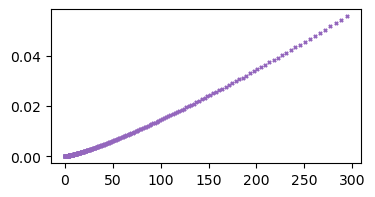

In [17]:
newton_plot(1e-1)

In [14]:
H[345]

15.855881143779056

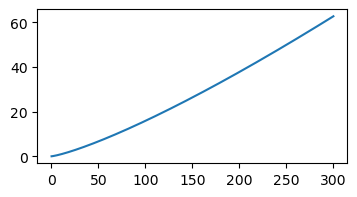

In [15]:
plt.plot(R, H)

In [287]:
g = lambda a: 2 * 3**-1.5 / H_R - k[0] / a
a_pop = []

root_list = []
lower_bounds = k[0]/a # lower bound for root finding

for i in range(len(a)):
    root_R = []
    lb_loc = lower_bounds[i] # local lower bound at specific grain size
    solution_check = np.sum(g(a[i])>0) # length of grain sizes that have solutions
    if solution_check == 0:
        a_pop.append(a[i])
        continue
    for j in range(solution_check):
        g_loc = lambda z: z / (1 + (H_R[j]*z)**2) ** (3/2) - k[0]/a[i]
        result = bisect(g_loc, lb_loc, 2**-0.5 / H_R[j], maxiter=2000)
        lb_loc = result-2
        root_R.append(result)
    root_R = np.array(root_R)
    root_full_R = np.full((P,), np.nan)
    root_full_R[:solution_check] = root_R
    root_list.append(root_full_R)

root_list = np.array(root_list)
a_1 = np.array(sorted(set(a) - set(a_pop)))

root_list_copy = np.copy(root_list)
root_list_copy[(root_list_copy > 10)] = np.nan
settle_idx = np.sum(np.sum(~np.isnan(root_list_copy), axis=1)==0)
a_2 = np.copy(a_1)[settle_idx:]
root_list_copy = root_list_copy[settle_idx:]

gs_list = np.sum(np.isnan(root_list_copy), axis=0)
scale = []
for l in range(len(gs_list)):
    scale.append(sd[l] / np.sum(a_2[gs_list[l]:]**0.5))

n_a = []
for i in range(len(a_2)):
    root_list_loc = root_list_copy[i]
    root_list_loc = root_list_loc[~np.isnan(root_list_loc)]
    n_ZR = np.zeros((N,P))
    for j in range(len(root_list_loc)):
        n_ZR[np.sum(root_list_loc[j] > z)-1, j] = scale[j] * a_2[i]**-2.5
    n_a_append = np.reshape(n_ZR, (1, N, P))
    n_a.append(n_a_append)

n_a = np.array(n_a)

print('Minimum grain size:', a_2[0]*1e4, "microns")
print('Maximum grain size:', a_2[-1]*1e4, "microns")
print('Number of grains:', len(a_2))

Minimum grain size: 0.10230348191004603 microns
Maximum grain size: 799.9999999999999 microns
Number of grains: 2639


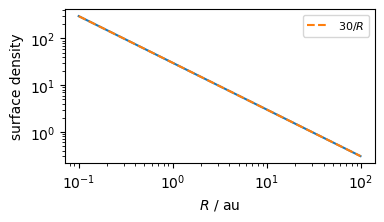

In [353]:
# mass_pgs = []
# for i in range(len(a_2)):
#     mass_pgs.append(a_2[i]**3 * n_a[i,0])
# mass_pgs = np.array(mass_pgs)

# plt.scatter(R, np.sum(np.sum(mass_pgs, axis=0), axis=0), marker='x', s=5)

plt.plot(R, np.sum(np.sum(n_a[:,0], axis=1) * np.tile(a_2**3, (300, 1)).T, axis=0))

plt.plot(R, 30/R, label=r'$30/R$', c='C1', ls='--')
plt.xscale('log')
plt.xlabel(r'$R$ / au')
plt.ylabel('surface density')
plt.yscale('log')
plt.legend(prop={'size': 8})

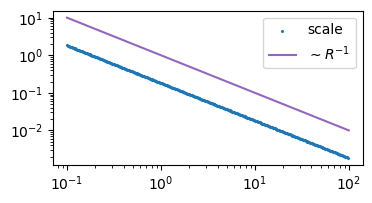

In [283]:
plt.scatter(R[:-1], scale, marker='x', s=2, label='scale')
plt.plot(R, 1/R, label=r'$\sim R^{-1}$', c='C4')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [270]:
density_grid = fits.PrimaryHDU(n_a)
grain_size = fits.ImageHDU(a_2*1e4)
density_grid.header['read_n_a'] = 0
hdulist = fits.HDUList([density_grid, grain_size])
hdulist.writeto('/data/jhyl3/mcfost_files/run_07/no_wind_density_6.fits', overwrite=True)

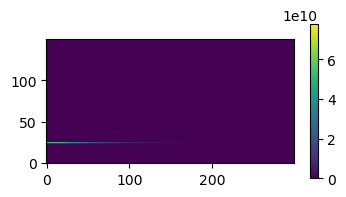

In [293]:
plt.imshow(n_a[500,0], origin='lower')
plt.colorbar()